In [106]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import cdist

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import make_h_combined, PC_axes, get_color_inds, name_best_ckpt, take_names

figpath = os.path.join(p,'code','overleaf','multitask-nets','v1_figs','figure4')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [124]:
def plot_task_layout(D_use,task_nums,trial_set = range(0,80,2),figsize = 4):
    fig = plt.figure(figsize=(figsize,figsize),tight_layout=True,facecolor='white')
    ax1 = plt.subplot(1,1,1)
    color_inds, color_inds_nu = get_color_inds()
    for t_num in range(len(task_nums)):
        c = color_inds_nu[task_nums[t_num]]
        trials_use = range(t_num*len(trial_set),(t_num+1)*len(trial_set))
        plt.plot(D_use[trials_use,0],D_use[trials_use,1],'.',c = c,alpha = .5)
        rule = rules_dict['all'][task_nums[t_num]]
        _, rule_name, _, _ = take_names('fix1',rule)
        plt.text(np.mean(D_use[trials_use,0])-.01,1.2*np.mean(D_use[trials_use,1]),
                 rule_name,color = c,fontsize = 20,weight="bold")
    
    PC_axes(ax1)
    
#     plt.ylim((-.07,.07))
#     plt.xlim((-0.01,.08))
    
    plt.ylim((-.1,.1))
    plt.xlim((.04,.08))
    
    task_list = [rules_dict['all'][x] for x in task_nums]
    
    figname = 'task_layout'+'_'.join(task_list)+'.pdf'
    plt.savefig(os.path.join(figpath,figname))
    
    figname = 'task_layout'+'_'.join(task_list)+'.png'
    plt.savefig(os.path.join(figpath,figname))
    print(os.path.join(figpath,figname))
    
    plt.show()
    
def PC_axes(ax):

    plt.xlabel('PC1',fontsize = 20)
    plt.ylabel('PC2',fontsize = 20)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [98]:
model_n = 1
task_list = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
#              'dm1', 'dm2', 'contextdm1', 'contextdm2', 'multidm',
             'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
             'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

# task_list = ['fdgo', 'fdanti', 'delaygo', 'delayanti']

rule = task_list[0]
which_net = 'l2h000001'
fldr = 'l2w0001'#'15_tasks'#'4_tasks'
supp = []#'long_train'

if fldr == '4_tasks':
    s = '_'
    rule_trains_str = s.join(task_list)
    file_spec = os.path.join(fldr,which_net+s+rule_trains_str)
elif fldr == 'single_tasks':
    rule_trains_str = task_list[0]
    file_spec = os.path.join(fldr,which_net,rule_trains_str)
elif fldr == '15_tasks':
    s = '_'
    rule_trains_str = s.join(task_list)
    file_spec = os.path.join(fldr,'1024_n_rnn/l2_w6_h7'+ rule_trains_str) 
elif fldr == 'l2w0001':
    file_spec = fldr
else:
    file_spec = which_net
    
dir_specific_all = os.path.join(p,'data/rnn/multitask/',net,'crystals','softplus',file_spec)#,supp)
m = os.path.join(dir_specific_all,str(model_n))

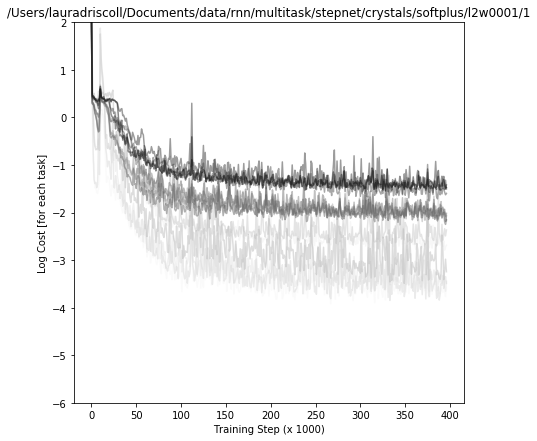

In [36]:
fig = plt.figure(figsize=(7, 7))
cmap=plt.get_cmap('Greys')


for r in range(len(task_list)):
    
    if fldr == 'single_tasks':
        rule_trains_str = task_list[r]
        file_spec = os.path.join(fldr,which_net,rule_trains_str)
        dir_specific_all = os.path.join(p,'data/rnn/multitask/',net,'crystals','softplus',file_spec)
        m = os.path.join(dir_specific_all,str(model_n))
        
    fname = os.path.join(m, 'log.json')
    with open(fname, 'r') as f:
        log_all = json.load(f)
        c = cmap((r+1)/(len(task_list)+1))
        ax = fig.add_subplot(1,1,1)
        x = np.log(log_all['cost_'+task_list[r]])
        plt.plot(x,'-',c = c,alpha = .5)
    
ax.set_xlabel('Training Step (x 1000)')
ax.set_ylabel('Log Cost [for each task]')
plt.ylim([-6,2])
# plt.xlim([150,250])
    
plt.title(m)
plt.show()    

In [73]:
ckpt_n = name_best_ckpt(m,'delaygo')
ckpt_n_dir = os.path.join(m,'ckpts/model.ckpt-' + str(int(ckpt_n)))

In [74]:
trial_set = range(80)
task_nums = [0,1,2,3,4,5,11,12,13,14,15,16,17,18,19] # all tasks
h_combined_all = make_h_combined(m,ckpt_n_dir,task_nums,trial_set,'fix1')

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1/ckpts/model.ckpt-377000


In [75]:
# task_nums = [0,2,3,5,11,12,13,14,15,16,17,18,19] #excludes reation timed tasks
# h_combined = make_h_combined(m,ckpt_n_dir,task_nums,trial_set,'fix1')

fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v1_figs/figure4/task_layoutfdgo_delaygo_fdanti_delayanti.png


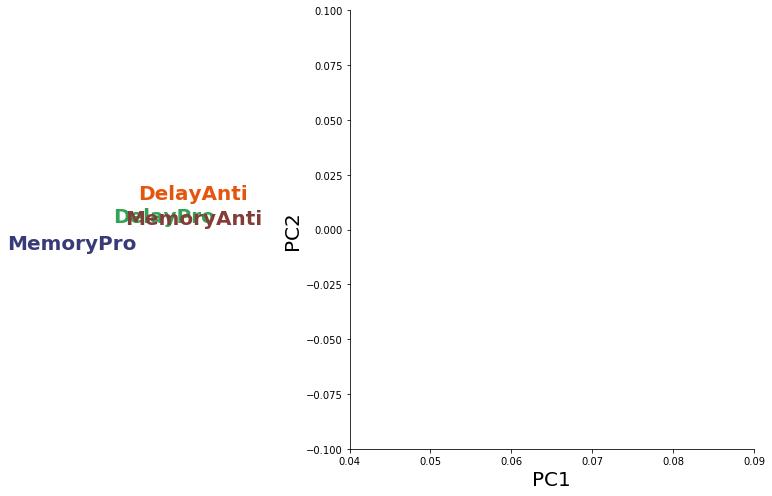

In [116]:
X = h_combined_all
pca = PCA(n_components = 3)
fp_pca = pca.fit_transform(X.T)
D_use = pca.components_.T
# D_use = D_use[:,1:]

plot_task_layout(D_use,task_nums,trial_set = trial_set,figsize = 7)

In [120]:
task_nums = [0,2,3,5]
h_combined_delay_mem = make_h_combined(m,ckpt_n_dir,task_nums,trial_set,'fix1')

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1/ckpts/model.ckpt-377000


fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v1_figs/figure4/task_layoutfdgo_delaygo_fdanti_delayanti.png


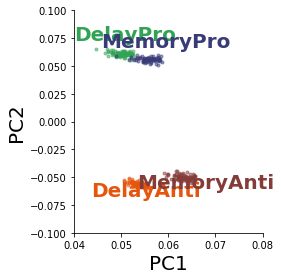

In [125]:
X = h_combined_delay_mem
pca = PCA(n_components = 3)
fp_pca = pca.fit_transform(X.T)
D_use = pca.components_.T
# D_use = D_use[:,[1,2]]

plot_task_layout(D_use,task_nums,trial_set = trial_set,figsize = 4)

In [126]:
task_nums = [11,12,13,14,15]
h_combined_context = make_h_combined(m,ckpt_n_dir,task_nums,trial_set,'fix1')

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1/ckpts/model.ckpt-377000


fix1
fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v1_figs/figure4/task_layoutdelaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm.png


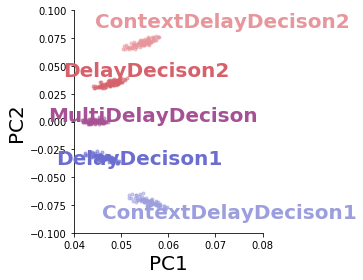

In [127]:
X = h_combined_context
pca = PCA(n_components = 3)
fp_pca = pca.fit_transform(X.T)
D_use = pca.components_.T

plot_task_layout(D_use,task_nums,trial_set = trial_set,figsize = 4)

In [129]:
task_nums = [1,2,4,5]
# h_combined_react_mem = make_h_combined(m,ckpt_n_dir,task_nums,trial_set,'fix1')

fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v1_figs/figure4/task_layoutreactgo_delaygo_reactanti_delayanti.png


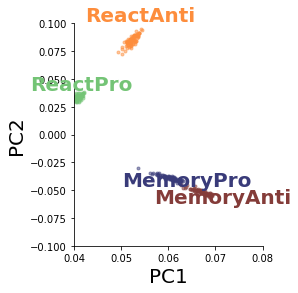

In [130]:
X = h_combined_react_mem
pca = PCA(n_components = 3)
fp_pca = pca.fit_transform(X.T)
D_use = pca.components_.T

plot_task_layout(D_use,task_nums,trial_set = trial_set,figsize = 4)

In [24]:
task_nums = [2,5,16,17]
h_combined_mem = make_h_combined(m,ckpt_n_dir,task_nums,trial_set,'fix1')

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/ckpts/model.ckpt-179000


fix1
fix1
fix1
fix1


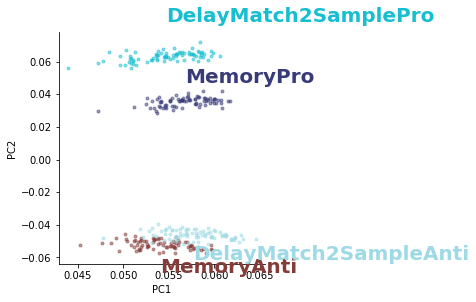

In [25]:
X = h_combined_mem
pca = PCA(n_components = 3)
fp_pca = pca.fit_transform(X.T)
D_use = pca.components_.T

plot_task_layout(D_use,task_nums,trial_set = trial_set,figsize = 4)